In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import utils
from scipy.optimize import minimize
import emcee

z = 0.0
cont = np.array([-5.69314816e-12, -1.78149645e-04,  5.68527108e-12])
sub = 0.1e-16

#### Functions

In [2]:
def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)
    return model

def plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)

    return diskout,narrowmodel,broadmodel

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 
        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0 

class logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(object):
    def __init__(self, x, y, yerr, lines, linesbroad, fixed, fitted, mins, maxes): 
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.linesbroad = linesbroad
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad,self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout, broadout = plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return diskout,narrowout,broadout

def loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0) 
    sigma2 = yerr**2  
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#### Spec

In [3]:
fn = '../../../spectra/ASASSN-18pg.txt'
wl, flux = np.loadtxt(fn, usecols=(2, 3), unpack=True)
flux -= power_law(wl, *cont) - sub
flux *= 1e17

olambda = 6563
wavemin = 6100
wavemax = 7000
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

In [4]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]

# Circular disk size and emission properties
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-8   # optical depth normalization (0=no wind)
eta = 0.8 #optical depth power-law index
anglam = 8 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
amp = 1.6 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 0 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)

# Narrow component
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 # Amplitude fraction the two narrow line components

# Broad component
broadwidth = 90 # width
broadHalphaflux = 40 # intensity

In [5]:
angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 10000
broadmin, broadmax = 0, 2000
ampmin, ampmax = 0.0, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -360, 360
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
broadwidthmin, broadwidthmax = 20, 500
broadHalphafluxmin, broadHalphafluxmax = 0.0, 300
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 0.0, 300
NIIbfluxmin, NIIbfluxmax = 0.0, 20
SIIbfluxmin, SIIbfluxmax = 0.0, 50
diskfluxmin, diskfluxmax = 1, 500

diskmins = [xi1min,xi2min,broadmin,angimin,narrowfracmin,narrowwidthmin,narrowwidth2min,broadwidthmin,broadHalphafluxmin,
            Halphafluxmin,NIIbfluxmin,diskfluxmin,ampmin,aobsmin]
diskmax  = [xi1max,xi2max,broadmax,angimax,narrowfracmax,narrowwidthmax,narrowwidth2max,broadwidthmax,broadHalphafluxmax,
            Halphafluxmax,NIIbfluxmax,diskfluxmax,ampmax,aobsmax]

In [6]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
linesbroad = [Halpha]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 2
NIIbflux = 2
diskflux = 5.5
SIIbflux = 0

In [7]:
angi = 17 #disk inclination angle (degrees)
xi1 = 1100 #inner disk radius (GM/c^2)
xi2 = 2900 #outer disk radius (multiple of xi1)
broad = 900 #broadening parameter (km/s)

xispin = 100 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 1500 #outer spiral arm radius radius (GM/c^2, 0=XI2)

fitted_labels = ['xi1','xi2','broad','angi','narrowfrac','narrowwidth','narrowwidth2','broadwidth','broadHalphaflux','Halphaflux','NIIbflux','diskflux', 'amp', 'aobs']
initial = [xi1,xi2,broad,angi,narrowfrac,narrowwidth,narrowwidth2,broadwidth,broadHalphaflux,Halphaflux,NIIbflux,diskflux,amp,aobs]
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','narms','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','anglam','t0','eta','SIIbflux']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,narms,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,anglam,t0,eta,SIIbflux]
fixed = dict(zip(fixed_labels,fixed_values))

In [8]:
modelguess = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)
disk,narrowlines,broadlines= plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)

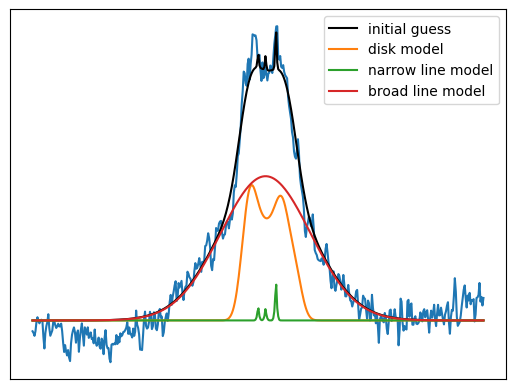

In [31]:
plt.plot(wl/(1+fixed['z']),flux)
plt.plot(wl/(1+fixed['z']),modelguess,color='black',label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='broad line model')
#plt.xlabel('Rest $\lambda$ ($\AA$)')
#plt.ylabel(r'f$_\lambda$ ' + ' (10$^{17}\cdot$erg/s/cm$^2$/Hz)')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
#plt.title('Initial guess -- ASASSN-18pg')
#plt.ylim(-10, 90)
plt.legend()
plt.savefig('initial-guess.png')
plt.show()

In [32]:
lp = logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(wl, flux, fluxerr, lines, linesbroad, fixed, fitted, diskmins, diskmax)

In [33]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values:', soln.x)

Best-fit parameter values: [ 8.89340121e+02  4.55069493e+03  4.82425737e+02  1.74077492e+01
  1.00026004e-01  2.55109910e+00  9.76193538e-01  8.92367209e+01
  3.96066569e+01  1.60035710e+00  1.86769422e+00  6.07939100e+00
  1.73132735e+00 -5.72804941e-04]


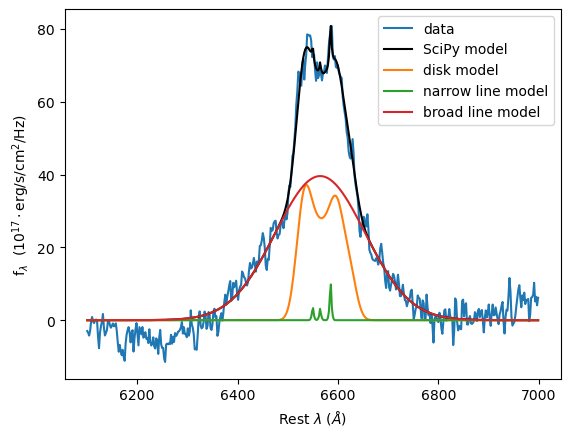

In [34]:
disk,narrowlines,broadlines = lp.plot(soln.x)
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,color='black',label='SciPy model')
plt.plot(wl/(1+fixed['z']),disk,label='disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='broad line model')
plt.xlabel('Rest $\lambda$ ($\AA$)')
plt.ylabel(r'f$_\lambda$ ' + ' (10$^{17}\cdot$erg/s/cm$^2$/Hz)')
#plt.title('SciPy Model')
plt.legend()
plt.savefig('scipy.png')
plt.show()